In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
"""Figure 2"""
import sys
sys.path.extend(['.', '..'])

import numpy as np
import matplotlib as mpl
from matplotlib import rc
rc('text', usetex='True')
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Wedge
import matplotlib.colors as mcolors
from matplotlib.legend_handler import HandlerPatch
import matplotlib.gridspec as gridspec
plt.style.use('./paper.mplstyle')

mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}',
    r'\usepackage{accents}',
    r'\DeclareSymbolFont{matha}{OML}{txmi}{m}{it}',
    r'\DeclareMathSymbol{\nu}{\mathord}{matha}{118}']
mpl.rcParams['text.latex.unicode'] = True

from scipy import interpolate
from tqdm import tqdm_notebook as tqdm
import shapely.geometry as sg
import shapely.ops as so

import warnings
with warnings.catch_warnings():
    import ternary

    warnings.simplefilter("ignore")
    from utils import fr as fr_utils
    from utils import misc as misc_utils
    from utils import plot as plot_utils

from unitarity import calc_unitarity_bounds
    
tRed = list(np.array([226,101,95]) / 255.)
tBlue = list(np.array([96,149,201]) / 255.)
tGreen = list(np.array([170,196,109]) / 255.)
grey = list(mcolors.to_rgb('grey'))
fontsize = 23
nbins = 25

In [3]:
s = [1, 0, 0]
m = fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))
print s, r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))
s = [0, 1, 0]
m = fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))
print s, r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))
s = [1, 2, 0]
m = fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))
print s, r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))
s = [0, 0, 1]
m = fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))
print s, r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))
m = [0.26, 0.418, 0.322]
print r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))
print map(float, fr_utils.angles_to_fr(fr_utils.fr_to_angles(m)))
m = [0.533, 0.230, 0.237]
print r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))
m = [0.206, 0.434, 0.361]
print r'-> [{0:6.3f} {1:6.3f} {2:6.3f}]'.format(*m), r'= [{0:6.3f} {1:6.3f}]'.format(*fr_utils.fr_to_angles(m))

[1, 0, 0] -> [ 0.550  0.183  0.267] = [ 0.537  0.501]
[0, 1, 0] -> [ 0.183  0.438  0.379] = [ 0.385 -0.410]
[1, 2, 0] -> [ 0.305  0.353  0.342] = [ 0.433 -0.072]
[0, 0, 1] -> [ 0.267  0.379  0.354] = [ 0.418 -0.174]
-> [ 0.260  0.418  0.322] = [ 0.460 -0.233]
[0.26, 0.4179999999999999, 0.32200000000000006]
-> [ 0.533  0.230  0.237] = [ 0.582  0.397]
-> [ 0.206  0.434  0.361] = [ 0.409 -0.356]


In [4]:
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height,
                       fontsize, trans):
        r = 10
        x = r + width//2 + 10
        y = height//2 - 3

        # create 
        p = Circle(xy=(x, y), radius=r)

        # update with data from oryginal object
        self.update_prop(p, orig_handle, legend)

        # move xy to legend
        p.set_transform(trans)

        return [p]

In [34]:
def alp(x):
    y = list(x)
    y[-1] = 0.7
    return y

def cmap_discretize(cmap, N):
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in xrange(N+1) ]
    # Return colormap object.
    return mpl.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

In [6]:
PS = 8.203e-20 # GeV^{-1}
PS_D6 = PS**2
print PS_D6

6.7289209e-39


In [63]:
# Load chains for NuFIT + BSM textures + HESE contour
SM_X = np.load('./chains/mc_x.npy')

T13_010 = np.genfromtxt('./frs/fr_DIM6_sfr_0_1_0_mfr_1_1_1_MixingScenario.T13_flat.txt')
T23_100 = np.genfromtxt('./frs/fr_DIM6_sfr_1_0_0_mfr_1_1_1_MixingScenario.T23_flat.txt')

# bc_chains = np.load('./chains/contour_REAL.npy')
# flavour_angles = bc_chains[:,-2:]
# flavour_ratios = np.array(
#     map(fr_utils.angles_to_fr, flavour_angles)
# )

In [64]:
# Process only n points for plotting
n = 10000
T13_010 = np.vstack([T13_010[T13_010[:,2]<0.1][:int(n/5.)], T13_010[T13_010[:,2]>=0.1][:int(4*n/5.)]])
T23_100 = np.vstack([T23_100[T23_100[:,0]<=0.9][:int(4*n/5.)], T23_100[T23_100[:,0]>0.9][:int(n/5.)]])

In [65]:
print T13_010.shape
print T23_100.shape

(10000, 4)
(10000, 4)


In [14]:
# Calculate unitary boundaries
f_s_120 = fr_utils.normalise_fr((1, 2, 0))
f_s_010 = fr_utils.normalise_fr((0, 1, 0))
f_s_100 = fr_utils.normalise_fr((1, 0, 0))

n_samples = 1000
f_m_120 = calc_unitarity_bounds(f_s_120, n_samples)
f_m_010 = calc_unitarity_bounds(f_s_010, n_samples)
f_m_100 = calc_unitarity_bounds(f_s_100, n_samples)

p1 = sg.Polygon(map(plot_utils.project, f_m_010))
p2 = sg.Polygon(map(plot_utils.project, f_m_100))
c = so.cascaded_union([p1,p2])
f_m_x = np.array(map(
    lambda x: plot_utils.project_toflavour(x, nbins), zip(*c.exterior.xy)
))

In [45]:
# Work out upper and lower axis
d = [T13_010, T23_100]
min_scale = 1E100
max_scale = -1E100

for i in d:
    min_scale = min_scale if min_scale < np.min(i[:,-1]) else np.min(i[:,-1])
    max_scale = max_scale if max_scale > np.max(i[:,-1]) else np.max(i[:,-1])

print 'min_scale', min_scale
print 'max_scale', max_scale

min_scale -= np.log10(PS_D6)
max_scale -= np.log10(PS_D6)

print 'min_scale', min_scale
print 'max_scale', max_scale

min_scale -52.0
max_scale -40.0
min_scale -13.827945423101944
max_scale -1.8279454231019443


In [66]:
# Colouring
cmap_g = mpl.colors.LinearSegmentedColormap.from_list("", ["lime", "gold", "darkorange"])
cmap_b = mpl.colors.LinearSegmentedColormap.from_list("", ["blue", "fuchsia", "darkmagenta"])
cmap_010 = cmap_discretize(cmap_g, 10)
cmap_100 = cmap_discretize(cmap_b, 10)
cmap_001 = cmap_discretize(cmap_b, 10)

norm = mpl.colors.Normalize(vmin=min_scale, vmax=max_scale)

color_010 = map(alp, map(cmap_010, map(norm, T13_010[:,-1]-np.log10(PS_D6))))
color_100 = map(alp, map(cmap_100, map(norm, T23_100[:,-1]-np.log10(PS_D6))))

In [17]:
# Calculate nufit boundary
polys = []
for x in (SM_X[SM_X[:,0]>=(1/3.)], SM_X[SM_X[:,0]<(1/3.)]):
    polys.append(plot_utils.flavour_contour(
        frs = x,
        plot = False,
        nbins = nbins,
        coverage = 95,
        oversample = 15,
        delaunay = True,
        d_alpha = 0.04,
        d_gauss = 0.02,
        smoothing = 4,
        hist_smooth = 0.03
    ))
p1 = sg.Polygon(polys[0])
p2 = sg.Polygon(polys[1])
nufit_bound = so.cascaded_union([p1,p2]).exterior.xy

../utils/plot.py:288: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a*b*c/(4.0*area)
../utils/plot.py:287: RuntimeWarning: invalid value encountered in sqrt
  area = np.sqrt(s*(s-a)*(s-b)*(s-c))
/home/shivesh/programs/anaconda2/lib/python2.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][300]=x[0][0]
  (i, m, i)))
/home/shivesh/programs/anaconda2/lib/python2.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][300]=x[1][0]
  (i, m, i)))


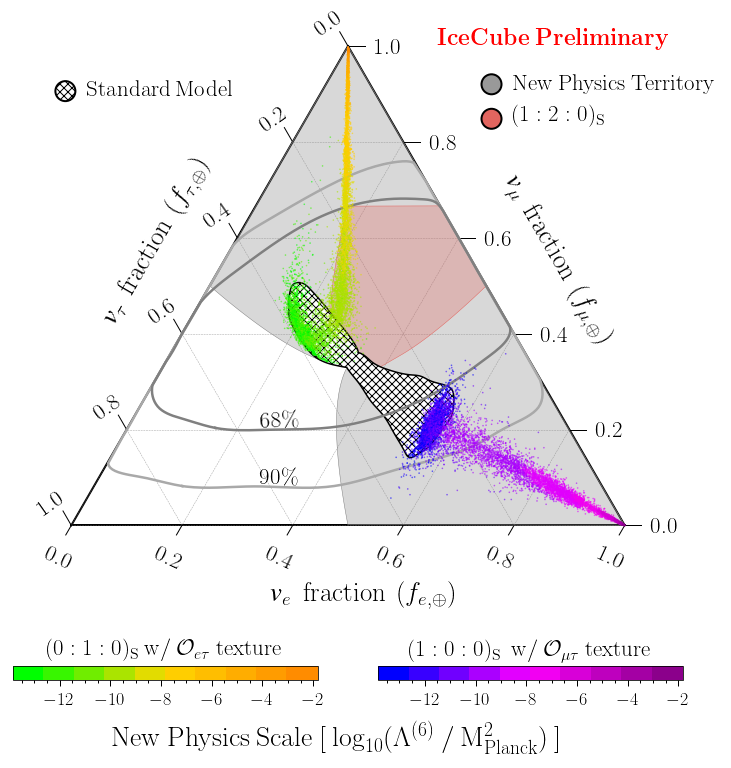

In [67]:
# Figure
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 1, height_ratios=[40, 1])
gs.update(hspace=0.3, wspace=0.15)

# Axis
ax = fig.add_subplot(gs[0])
ax_labels = [r'$\nu_e\:\:{\rm fraction}\:\left( f_{e,\oplus}\right)$',
             r'$\nu_\mu\:\:{\rm fraction}\:\left( f_{\mu,\oplus}\right)$',
             r'$\nu_\tau\:\:{\rm fraction}\:\left( f_{\tau,\oplus}\right)$']
tax = plot_utils.get_tax(ax, scale=nbins, ax_labels=ax_labels, rot_ax_labels=True)

# Plot HESE contour
coverages = {68: 'grey', 90: 'darkgrey'}
for cov in coverages.iterkeys():
    plot_utils.flavour_contour(
        frs = flavour_ratios,
        ax = ax,
        nbins = nbins,
        coverage = cov,
        linewidth = 2.5,
        color = coverages[cov],
        alpha = 1,
        zorder = 6
    )
# Text
ax.text(0.34*nbins, 0.18*nbins, r'$68\%$', fontsize=fontsize, rotation=3)
ax.text(0.34*nbins, 0.075*nbins, r'$90\%$', fontsize=fontsize, rotation=0)

# # Plot BSM scatter
tax.scatter(T13_010[:,:-1]*nbins, marker='.', s=2, alpha=0.5, color=color_010, zorder=8)
tax.scatter(T23_100[:,:-1]*nbins, marker='.', s=2, alpha=0.5, color=color_100, zorder=8)

# Plot unitary regions
for f_m, col in reversed(zip((f_m_120, f_m_x), (tRed, grey))):
    plot_utils.tax_fill(
        ax=ax,
        points=f_m,
        nbins=nbins,
        linewidth = 0.5,
        facecolor = col+[0.3],
        edgecolor = col,
        zorder = 3
    )

# Plot NuFIT boundary
ax.fill(
    nufit_bound[0], nufit_bound[1],
    linewidth = 1.5,
    edgecolor = 'None',
    facecolor = 'white',
    alpha = 1,
    zorder = 4,
)
ax.fill(
    nufit_bound[0], nufit_bound[1], 
    linewidth = 1.5,
    edgecolor = 'k',
    facecolor = 'None',
    alpha = 1,
    zorder = 5,
    hatch = 'XXX'
)

# Legend Right
l_size = fontsize
legend_elements = []
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor=grey+[0.8], edgecolor='k',
           linewidth=2., label=r'$\rm New\:Physics\:Territory$')
)
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor=tRed, edgecolor='k',
           linewidth=2., label=r'$(1:2:0\smash{)_{\rm S}}$')
)
legend = plt.legend(
    handles=legend_elements,
    loc=(0.65, 0.8),
    fontsize=l_size,
    handler_map={Circle: HandlerCircle()}
)
plt.setp(legend.get_title(), fontsize=l_size)
legend.get_frame().set_linestyle('-')
ax.add_artist(legend)

# Legend Left
legend_elements = []
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='none', hatch='XXX', edgecolor='k',
           linewidth=2., label=r'$\rm Standard\:Model$')
)
legend = plt.legend(
    handles=legend_elements,
    loc=(-0.05, 0.85),
    fontsize=l_size,
    handler_map={Circle: HandlerCircle()}
)
plt.setp(legend.get_title(), fontsize=l_size)
legend.get_frame().set_linestyle('-')

# Colorbar Left
gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1])
ax0 = fig.add_subplot(gs00[0])
cb = mpl.colorbar.ColorbarBase(
    ax0, cmap=cmap_010, norm=norm, orientation='horizontal'
)
cb.ax.tick_params(labelsize=fontsize-5)
ax0.text(
    0.5, 2, r'$(0:1:0\smash{)_{\rm S}}\:{\rm w}/\:\mathcal{O}_{e\tau}\:{\rm texture}$',
    fontsize=fontsize, rotation=0, verticalalignment='center', horizontalalignment='center'
)

# Colorbar Right
ax1 = fig.add_subplot(gs00[1])
cb = mpl.colorbar.ColorbarBase(
    ax1, cmap=cmap_100, norm=norm, orientation='horizontal'
)
cb.ax.tick_params(labelsize=fontsize-5)
ax1.text(
    0.5, 2, r'$(1:0:0\smash{)_{\rm S}}\:\:{\rm w}/\:\mathcal{O}_{\mu\tau}\:{\rm texture}$',
    fontsize=fontsize, rotation=0, verticalalignment='center', horizontalalignment='center'
)

# Figure text
fig.text(
    0.5, 0.038, r'${\rm New\:Physics\:Scale}\:[\:{\rm log}_{10} (\Lambda^{(6)}\:/\:{\rm M}^{2}_{\rm Planck})\: ]$',
    fontsize=fontsize+5, horizontalalignment='center'
)
fig.text(
    0.75, 0.86, r'${\rm\bf IceCube\:Preliminary}$', fontsize=fontsize,
    horizontalalignment='center', color='r'
)

# Save
fig.savefig('./plots/fig2.png', bbox_inches='tight', dpi=150)
fig.savefig('./plots/fig2.pdf', bbox_inches='tight', dpi=150)